# Periodic download of IEX stock-ticker data

## Read IEX API credentials from `~/.config/iex.ini`

In [1]:
from pathlib import Path
config_path = Path.home() / '.config' / 'iex.ini'

from configparser import ConfigParser
config = ConfigParser()
config.read(str(config_path))
iex_config = config['iex']

api = 'https://cloud.iexapis.com'
public_key = iex_config['public_key']
secret_key = iex_config['secret_key']

In [2]:
# tickers = sorted("MMM ABT ABBV ABMD ACN ATVI ADBE AMD AAP AES AMG AFL A APD AKAM ALK ALB ARE ALXN ALGN ALLE AGN ADS LNT ALL GOOGL GOOG MO AMZN AMCR AEE AAL AEP AXP AIG AMT AWK AMP ABC AME AMGN APH ADI ANSS ANTM AON AOS APA AIV AAPL AMAT APTV ADM ARNC ANET AJG AIZ ATO T ADSK ADP AZO AVB AVY BKR BLL BAC BK BAX BBT BDX BRK.B BBY BIIB BLK HRB BA BKNG BWA BXP BSX BMY AVGO BR BF.B CHRW COG CDNS CPB COF CPRI CAH KMX CCL CAT CBOE CBRE CBS CDW CE CELG CNC CNP CTL CERN CF SCHW CHTR CVX CMG CB CHD CI XEC CINF CTAS CSCO C CFG CTXS CLX CME CMS KO CTSH CL CMCSA CMA CAG CXO COP ED STZ COO CPRT GLW CTVA COST COTY CCI CSX CMI CVS DHI DHR DRI DVA DE DAL XRAY DVN FANG DLR DFS DISCA DISCK DISH DG DLTR D DOV DOW DTE DUK DRE DD DXC ETFC EMN ETN EBAY ECL EIX EW EA EMR ETR EOG EFX EQIX EQR ESS EL EVRG ES RE EXC EXPE EXPD EXR XOM FFIV FB FAST FRT FDX FIS FITB FE FRC FISV FLT FLIR FLS FMC F FTNT FTV FBHS FOXA FOX BEN FCX GPS GRMN IT GD GE GIS GM GPC GILD GL GPN GS GWW HAL HBI HOG HIG HAS HCA HCP HP HSIC HSY HES HPE HLT HFC HOLX HD HON HRL HST HPQ HUM HBAN HII IEX IDXX INFO ITW ILMN IR INTC ICE IBM INCY IP IPG IFF INTU ISRG IVZ IPGP IQV IRM JKHY JEC JBHT SJM JNJ JCI JPM JNPR KSU K KEY KEYS KMB KIM KMI KLAC KSS KHC KR LB LHX LH LRCX LW LVS LEG LDOS LEN LLY LNC LIN LKQ LMT L LOW LYB MTB MAC M MRO MPC MKTX MAR MMC MLM MAS MA MKC MXIM MCD MCK MDT MRK MET MTD MGM MCHP MU MSFT MAA MHK TAP MDLZ MNST MCO MS MOS MSI MSCI MYL NDAQ NOV NTAP NFLX NWL NEM NWSA NWS NEE NLSN NKE NI NBL JWN NSC NTRS NOC NCLH NRG NUE NVDA NVR ORLY OXY OMC OKE ORCL PCAR PKG PH PAYX PYPL PNR PBCT PEP PKI PRGO PFE PM PSX PNW PXD PNC PPG PPL PFG PG PGR PLD PRU PEG PSA PHM PVH QRVO PWR QCOM DGX RL RJF RTN O REG REGN RF RSG RMD RHI ROK ROL ROP ROST RCL CRM SBAC SLB STX SEE SRE SHW SPG SWKS SLG SNA SO LUV SPGI SWK SBUX STT SYK STI SIVB SYMC SYF SNPS SYY TMUS TROW TTWO TPR TGT TEL FTI TFX TXN TXT TMO TIF TWTR TJX TSCO TDG TRV TRIP TSN UDR ULTA USB UAA UA UNP UAL UNH UPS URI UTX UHS UNM VFC VLO VAR VTR VRSN VRSK VZ VRTX VIAB V VNO VMC WAB WMT WBA DIS WM WAT WEC WCG WFC WELL WDC WU WRK WY WHR WMB WLTW WYNN XEL XRX XLNX XYL YUM ZBH ZION ZTS".split(" "))
# aapl = tickers.index('AAPL'); aapl
ticker = 'AAPL'
tickers = [ticker]
num_tickers = len(tickers)
num_tickers

1

In [3]:
from datetime import datetime as dt, timedelta as Δ
from dateutil.parser import parse

strptime = dt.strptime
time = dt.now
now = time()
today = now.date()
today.strftime('%Y-%m-%d')

'2019-11-03'

In [4]:
data_dir = Path.cwd() / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

In [5]:
from sys import executable as python
!{python} -m pip install -Uq requests
from requests import get as GET

In [6]:
import json

def fetch(date, ticker, refetch_empty=False):
    date_str = date.strftime('%Y%m%d')
    out_path = data_dir / ('%s-%s' % (date_str, ticker))
    refetch = False
    if out_path.exists():
        if refetch_empty:
            with out_path.open('r') as f:
                data = json.load(f)
                if not data:
                    refetch = True
                    print('Re-fetching data for %s from %s' % (ticker, date_str))
                else:
                    return True
        else:
            return True
    else:
        print('Fetching data for %s from %s' % (ticker, date_str))

    url = f'https://cloud.iexapis.com/stable/stock/{ticker}/chart/date/{date_str}?token={secret_key}'
    resp = GET(url)
    resp.raise_for_status()
    with out_path.open('wb') as f:
        f.write(resp.content)

    data = json.loads(resp.content)
    if data:
        if refetch:
            print('Re-fetch found data for %s %s' % (date_str, ticker))
        return True

    return False

In [8]:
%%time
from concurrent.futures import ThreadPoolExecutor

end_date = today
start_date = dt(2019, 4, 1).date()
N = 32
refetch_empty = False

def get_dates(start_date, end_date, step=1):
    date = start_date
    while date != end_date:
        if date.weekday() <= 4:
            yield date
        date += Δ(days=step)

dates = list(get_dates(start_date, end_date))

with ThreadPoolExecutor(max_workers = N) as p:
    results = p.map(
        lambda t: fetch(t[0], t[1], refetch_empty=refetch_empty), 
        [ (date, ticker) for date in dates for ticker in tickers ]
    )
    
    found_data = True in results
    if not found_data:
        print('No data found for %s' % date)

CPU times: user 14 ms, sys: 6.43 ms, total: 20.5 ms
Wall time: 16.7 ms


In [9]:
!{python} -m pip install -Uq pandas
from pandas import concat, DataFrame as DF, read_csv, read_json
import pandas as pd

In [10]:
minutes = 390  # [9:30am,4:00pm)

In [11]:
features = [ 'open', 'close', 'high', 'low', 'average', 'volume', 'notional', 'numberOfTrades' ]
num_features = len(features)

In [12]:
def load_data_arr(date, ticker):
    date_str = date.strftime('%Y%m%d')
    out_path = data_dir / ('%s-%s' % (date_str, ticker))
    if not out_path.exists():
        arr = zeros((minutes, len(features)))
        arr[:] = nan
        return arr
    df = read_json(out_path)
    if df.empty:
        arr = zeros((minutes, len(features)))
        arr[:] = nan
        return arr
    arr = df[features].values
    assert arr.shape == (minutes, len(features))
    return arr

In [13]:
!{python} -m pip install -Uq joblib matplotlib numpy scipy
import numpy as np
from numpy import array, nan, zeros, count_nonzero as cnz, isnan as na, mean, std, unique
from numpy.random import shuffle, permutation
from joblib import Parallel, delayed
from scipy.stats import describe

In [14]:
def load_date_arr(date):
    arr = array([ 
        load_data_arr(start_date, ticker) 
        for ticker in tickers 
    ]) \
    .reshape((
        minutes, 
        len(tickers), 
        len(features),
    ))
    assert arr.shape == (minutes, num_tickers, len(features))
    return arr

In [15]:
def load_ticker_date_df(date, ticker):
    date_str = date.strftime('%Y%m%d')
    out_path = data_dir / ('%s-%s' % (date_str, ticker))
    if not out_path.exists():
        return None
    df = read_json(out_path)
    if df.empty:
        return None
    df['datetime'] = df['date'].apply(lambda d: d.strftime('%Y-%m-%d')) + ' ' + df['minute']
    df.drop(columns=['date', 'minute'])
    df = df[['datetime'] + features]
    df['datetime'] = df['datetime'].apply(lambda s: strptime(s, '%Y-%m-%d %H:%M'))
    return df

In [16]:
def load_ticker_df(ticker, N=None, limit=None):
    if limit is None:
        ds = dates
    else:
        ds = dates[:limit]

    if N is None:
        df = concat([ load_ticker_date_df(date, ticker) for date in ds ])
    else:
        df = concat(Parallel(n_jobs=N)( delayed(load_ticker_date_df)(date, ticker) for date in ds ))
    
    df.set_index('datetime', inplace=True)
    df.sort_index(inplace=True)

    for col in features:
        df[col] = df[col].apply(lambda n: nan if n < 0 else n)

    return df

In [156]:
%%time
aapl = load_ticker_df('AAPL'); aapl

CPU times: user 4.58 s, sys: 86.3 ms, total: 4.67 s
Wall time: 5.05 s


,open,close,high,low,average,volume,notional,numberOfTrades
datetime,,,,,,,,
2019-04-01 09:30:00,191.645,190.650,191.645,190.60,191.189,4320,825935.940,44
2019-04-01 09:31:00,190.700,190.980,190.980,190.64,190.761,3246,619210.510,32
2019-04-01 09:32:00,191.060,190.930,191.090,190.78,190.951,2253,430211.740,30
2019-04-01 09:33:00,190.980,190.830,191.010,190.76,190.946,2241,427911.290,27
2019-04-01 09:34:00,190.760,190.700,190.760,190.60,190.666,1069,203822.465,12
...,...,...,...,...,...,...,...,...
2019-11-01 15:55:00,255.350,255.540,255.620,255.29,255.528,4917,1256432.140,36
2019-11-01 15:56:00,255.530,255.730,255.750,255.52,255.616,4788,1223891.590,42
2019-11-01 15:57:00,255.740,255.730,255.880,255.73,255.822,3798,971613.530,38


In [157]:
aapl.count()

open              55577
close             55577
high              55577
low               55577
average           55577
volume            56367
notional          56367
numberOfTrades    56367
dtype: int64

In [158]:
nan_idxs = aapl.isna().any(axis=1); nan_idxs
nans = aapl[nan_idxs]
nans

,open,close,high,low,average,volume,notional,numberOfTrades
datetime,,,,,,,,
2019-04-02 13:29:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-04-05 13:36:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-04-05 14:29:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-04-15 13:33:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-04-16 13:39:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
...,...,...,...,...,...,...,...,...
2019-11-01 12:46:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-11-01 13:24:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0
2019-11-01 13:29:00,NaN,NaN,NaN,NaN,NaN,0,0.0,0


In [159]:
last_valid_idx = -1
last_close = nan
last_closes = []
for idx, valid in enumerate(~nan_idxs):
    last_closes.append(last_close)
    if valid:
        last_valid_idx = idx
        last_close = aapl['close'].iloc[idx]
last_closes

[nan,
 190.65,
 190.98,
 190.93,
 190.83,
 190.7,
 190.85,
 190.77,
 190.71,
 190.3,
 190.34,
 190.53,
 190.07,
 190.13,
 190.2,
 190.35,
 190.12,
 190.19,
 190.27,
 190.13,
 190.27,
 190.24,
 190.365,
 190.34,
 190.165,
 189.72,
 189.95,
 190.19,
 190.2,
 190.17,
 190.15,
 190.35,
 190.37,
 190.3,
 190.41,
 190.09,
 189.92,
 189.57,
 189.02,
 189.09,
 189.24,
 188.95,
 188.8,
 189.1,
 188.98,
 189.115,
 189.28,
 189.35,
 189.37,
 189.29,
 189.39,
 189.17,
 189.09,
 189.11,
 189.15,
 188.86,
 188.85,
 188.79,
 188.64,
 188.76,
 188.945,
 188.99,
 188.83,
 188.9,
 188.795,
 188.875,
 188.73,
 188.805,
 188.735,
 188.64,
 188.7,
 188.69,
 188.6,
 188.68,
 188.54,
 188.475,
 188.62,
 188.74,
 188.84,
 188.83,
 188.95,
 188.915,
 189.05,
 189.02,
 189.02,
 189.21,
 189.29,
 189.44,
 189.41,
 189.35,
 189.4,
 189.5,
 189.47,
 189.84,
 190.09,
 190.0,
 190.085,
 190.285,
 190.25,
 190.265,
 190.19,
 190.13,
 190.13,
 190.2,
 190.21,
 190.15,
 190.11,
 190.16,
 190.09,
 190.08,
 189.94,
 189.

In [160]:
aapl['prev_close'] = last_closes
aapl

,open,close,high,low,average,volume,notional,numberOfTrades,prev_close
datetime,,,,,,,,,
2019-04-01 09:30:00,191.645,190.650,191.645,190.60,191.189,4320,825935.940,44,NaN
2019-04-01 09:31:00,190.700,190.980,190.980,190.64,190.761,3246,619210.510,32,190.650
2019-04-01 09:32:00,191.060,190.930,191.090,190.78,190.951,2253,430211.740,30,190.980
2019-04-01 09:33:00,190.980,190.830,191.010,190.76,190.946,2241,427911.290,27,190.930
2019-04-01 09:34:00,190.760,190.700,190.760,190.60,190.666,1069,203822.465,12,190.830
...,...,...,...,...,...,...,...,...,...
2019-11-01 15:55:00,255.350,255.540,255.620,255.29,255.528,4917,1256432.140,36,255.300
2019-11-01 15:56:00,255.530,255.730,255.750,255.52,255.616,4788,1223891.590,42,255.540
2019-11-01 15:57:00,255.740,255.730,255.880,255.73,255.822,3798,971613.530,38,255.730


In [161]:
aapl.count()

open              55577
close             55577
high              55577
low               55577
average           55577
volume            56367
notional          56367
numberOfTrades    56367
prev_close        56366
dtype: int64

In [182]:
nan_cols = [ 'open', 'close', 'high', 'low', 'average' ]
lg = aapl.copy()
for col in nan_cols:
    lg[col].fillna(lg.prev_close, inplace=True)
    lg[col] = np.log(lg[col] / aapl.prev_close)

lg.drop(columns='prev_close', inplace=True)
lg.dropna(how='any', inplace=True)
lg[nan_cols][nan_idxs]

/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,open,close,high,low,average
datetime,,,,,
2019-04-02 13:29:00,0.0,0.0,0.0,0.0,0.0
2019-04-05 13:36:00,0.0,0.0,0.0,0.0,0.0
2019-04-05 14:29:00,0.0,0.0,0.0,0.0,0.0
2019-04-15 13:33:00,0.0,0.0,0.0,0.0,0.0
2019-04-16 13:39:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-11-01 12:46:00,0.0,0.0,0.0,0.0,0.0
2019-11-01 13:24:00,0.0,0.0,0.0,0.0,0.0
2019-11-01 13:29:00,0.0,0.0,0.0,0.0,0.0


In [183]:
lg.count()

open              56366
close             56366
high              56366
low               56366
average           56366
volume            56366
notional          56366
numberOfTrades    56366
dtype: int64

In [184]:
lg.drop(columns=[ 'volume', 'notional', 'numberOfTrades' ], inplace=True)
lg['trades'] = np.sqrt(aapl.numberOfTrades)
lg['avgVol'] = np.log(1 + (aapl.volume / aapl.numberOfTrades).fillna(0))
lg.rename(columns={'average': 'avg', 'high': 'hi', 'low': 'lo'}, inplace=True)
lg['next_close'] = lg.close.shift(-1)
lg.dropna(how='any', inplace=True)
lg

,open,close,hi,lo,avg,trades,avgVol,next_close
datetime,,,,,,,,
2019-04-01 09:31:00,0.000262,0.001729,0.001729,-0.000052,0.000582,5.656854,4.629253,-0.000262
2019-04-01 09:32:00,0.000419,-0.000262,0.000576,-0.001048,-0.000152,5.477226,4.332048,-0.000524
2019-04-01 09:33:00,0.000262,-0.000524,0.000419,-0.000891,0.000084,5.196152,4.430817,-0.000681
2019-04-01 09:34:00,-0.000367,-0.000681,-0.000367,-0.001206,-0.000860,3.464102,4.500735,0.000786
2019-04-01 09:35:00,0.000577,0.000786,0.001153,0.000315,0.000776,5.744563,5.002725,-0.000419
...,...,...,...,...,...,...,...,...
2019-11-01 15:54:00,-0.000078,0.000313,0.000548,-0.000333,0.000184,6.082763,4.565755,0.000940
2019-11-01 15:55:00,0.000196,0.000940,0.001253,-0.000039,0.000893,6.000000,4.924230,0.000743
2019-11-01 15:56:00,-0.000039,0.000743,0.000821,-0.000078,0.000297,6.480741,4.744932,0.000000


In [168]:
from random import random, seed
validation_split = 0.1

# decide whether a given minute should be treated as a validation (otherwise: training) test case
# seed PRNG so that this info is stable over time, and we never train on samples marked for "validation"
def get_validation_flag(dt):
    seed(int(dt.strftime('%Y%m%d%H%M')))
    return random() < validation_split

vfs = aapl.index.to_series().apply(get_validation_flag); vfs
nt, nv = vfs[~vfs].count(), vfs[vfs].count()
n = nt + nv
nt / n, nv / n

(0.8986286302269059, 0.10137136977309419)

In [191]:
lg_t = lg[~vfs]
lg_v = lg[ vfs]
means = lg_t.mean(axis=0).rename('μ')
stddevs = lg_t.std(axis=0).rename('σ')
concat([ means, stddevs ], axis=1)

/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,μ,σ
open,0.000008,0.000628
close,0.000004,0.000848
hi,0.000284,0.000757
lo,-0.000277,0.000793
avg,0.000008,0.000735
trades,3.716125,1.791973
avgVol,4.404496,0.749121
next_close,0.000004,0.000871


In [193]:
normed = lg.copy()
for col in normed.columns:
    normed[col] = (normed[col] - means[col]) / stddevs[col]

trn = normed[~vfs]
val = normed[ vfs]
concat([
    trn.mean(axis=0).rename('trn_μ'),
    trn.std(axis=0).rename('trn_σ'),
    val.mean(axis=0).rename('val_μ'),
    val.std(axis=0).rename('val_σ'),
    normed.mean(axis=0).rename('μ'),
    normed.std(axis=0).rename('σ'),
], axis=1)

/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,trn_μ,trn_σ,val_μ,val_σ,μ,σ
open,-1.830438e-16,1.0,0.008846,1.256577,0.000897,1.028919
close,1.420224e-16,1.0,0.008795,1.151217,0.000892,1.016347
hi,1.138742e-15,1.0,0.017563,1.223153,0.001780,1.024839
lo,-3.436155e-15,1.0,0.003394,1.115656,0.000344,1.012317
avg,6.711621e-18,1.0,0.010794,1.167755,0.001094,1.018259
trades,4.206237e-13,1.0,0.013656,1.015576,0.001384,1.001589
avgVol,5.897275e-13,1.0,-0.005247,1.001019,-0.000532,1.000096
next_close,-1.679045e-16,1.0,0.008066,0.893534,0.000818,0.989724


In [ ]:
cols = features + [ 'next_close' ]
trn = aapl[~aapl.validation][cols]
val = aapl[ aapl.validation][cols]
stats = \
    concat(
        [ 
            trn.mean(axis=0).rename('mean'), 
            trn.std(axis=0).rename('stddev') 
        ], 
        axis=1
    ) \
    .transpose(copy=True)

means = stats.loc['mean']
stddevs = stats.loc['stddev']

stats

In [117]:
aapl['avgVolume'] = aapl.volume / aapl.numberOfTrades
aapl['avgNotional'] = aapl.notional / aapl.numberOfTrades / aapl.average

In [88]:
aapl.numberOfTrades = 2*np.sqrt(aapl.numberOfTrades + 3/8)
aapl.volume = np.log(aapl.volume)
aapl.notional = np.log(aapl.notional)

/Users/ryan/.pyenv/versions/notebooks-3.7.4/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
concat([ aapl.mean(axis=0).rename('mean'), aapl.std(axis=0).rename('std') ], axis=1)

,mean,std
open,0.000009,0.000646
close,0.000005,0.000862
high,0.000285,0.000776
low,-0.000276,0.000802
average,0.000009,0.000749
volume,1751.279654,3160.715511
notional,358045.979314,669032.061133
numberOfTrades,17.050332,18.308183


In [66]:
np.log(aapl.average / (aapl.notional / aapl.volume)).dropna()

datetime
2019-04-01 09:31:00   -12.699977
2019-04-01 09:32:00          NaN
2019-04-01 09:33:00   -14.639109
2019-04-01 09:34:00          NaN
2019-04-01 09:35:00   -12.413109
                         ...    
2019-11-01 15:55:00   -12.564628
2019-11-01 15:56:00   -13.664228
2019-11-01 15:57:00   -13.474752
2019-11-01 15:58:00          NaN
2019-11-01 15:59:00   -13.639239
Length: 56366, dtype: float64

In [67]:
n = aapl.numberOfTrades
at = np.sqrt(n+3/8)*2

In [68]:
n.mean(), n.std()

(17.050331760281022, 18.308183189456013)

In [69]:
at.mean(), at.std()

(7.573957362366743, 3.512366123030434)

In [73]:
describe(n)

DescribeResult(nobs=56366, minmax=(0, 470), mean=17.050331760281022, variance=335.1895716986798, skewness=4.22763093700614, kurtosis=39.23777480192121)

In [72]:
describe(at)

DescribeResult(nobs=56366, minmax=(1.224744871391589, 43.376260788592646), mean=7.573957362366743, variance=12.336715782211842, skewness=1.2807409979164992, kurtosis=3.591496810873477)

In [104]:
describe(aapl.numberOfTrades)

DescribeResult(nobs=56366, minmax=(0, 470), mean=17.050331760281022, variance=335.1895716986798, skewness=4.22763093700614, kurtosis=39.23777480192121)

In [119]:
describe(aapl.avgNotional.dropna())

DescribeResult(nobs=55577, minmax=(0.9999976018379515, 37549.98057586837), mean=100.10958750694473, variance=73293.61377892568, skewness=95.19548000929716, kurtosis=10532.277160006553)

In [104]:
describe(aapl.numberOfTrades)

DescribeResult(nobs=56366, minmax=(0, 470), mean=17.050331760281022, variance=335.1895716986798, skewness=4.22763093700614, kurtosis=39.23777480192121)

In [121]:
aapl.avgVolume[aapl.avgVolume == 0]

Series([], Name: avgVolume, dtype: float64)

In [122]:
aapl.avgVolume.fillna(0, inplace=True)

In [120]:
describe(aapl.axvgVolume.dropna())

DescribeResult(nobs=55577, minmax=(1.0, 37550.0), mean=100.1095670608824, variance=73293.61779824518, skewness=95.19551247020952, kurtosis=10532.285752374855)

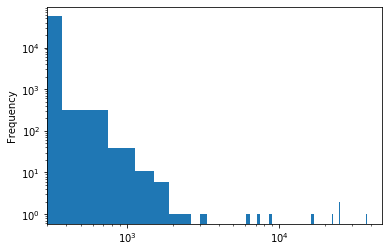

In [125]:
aapl.avgVolume.plot(kind='hist', bins=100, loglog=True)

In [144]:
av = av.loc[av > 0]

In [126]:
av = aapl.avgVolume

In [141]:
av[av == 0]

datetime
2019-04-02 13:29:00    0.0
2019-04-05 13:36:00    0.0
2019-04-05 14:29:00    0.0
2019-04-15 13:33:00    0.0
2019-04-16 13:39:00    0.0
                      ... 
2019-11-01 12:46:00    0.0
2019-11-01 13:24:00    0.0
2019-11-01 13:29:00    0.0
2019-11-01 13:45:00    0.0
2019-11-01 14:37:00    0.0
Name: avgVolume, Length: 790, dtype: float64

In [145]:
describe(np.sqrt(av)), describe(np.log(av+1)), describe(2*np.sqrt(np.log(av+1) + 3/8))

(DescribeResult(nobs=55577, minmax=(1.0, 193.77822375076101), mean=9.584271697403004, variance=8.251451560061255, skewness=16.673988122242726, kurtosis=807.4332982052475),
 DescribeResult(nobs=55577, minmax=(0.6931471805599453, 10.533455287996134), mean=4.466715293256196, variance=0.289625082817358, skewness=-2.1017363918323535, kurtosis=16.945182124553863),
 DescribeResult(nobs=55577, minmax=(2.0670241223168593, 6.605590144111617), mean=4.392204861909396, variance=0.0753989807022269, skewness=-3.7199164967863863, kurtosis=27.70041079047571))

In [129]:
describe(np.sqrt(av))

DescribeResult(nobs=56367, minmax=(0.0, 193.77822375076101), mean=9.449945324863249, variance=9.405202396516474, skewness=13.213609218737515, kurtosis=615.6922481147267)

In [128]:
describe(np.log(av+1))

DescribeResult(nobs=56367, minmax=(0.0, 10.533455287996134), mean=4.4041129713005756, variance=0.5612784200536695, skewness=-3.487236399827864, kurtosis=18.738566631211075)

In [133]:
describe(2*np.sqrt(np.log(av+1) + 3/8))

DescribeResult(nobs=56367, minmax=(1.224744871391589, 6.605590144111617), mean=4.347811983230221, variance=0.21298662225141307, skewness=-5.014332600434115, kurtosis=29.908327364900295)

In [135]:
describe(np.sqrt(aapl.volume))

DescribeResult(nobs=56367, minmax=(0.0, 447.82585901218346), mean=36.20257323787397, variance=440.70673523290276, skewness=2.3277254409765837, kurtosis=21.48437345844377)

In [138]:
describe(np.log(aapl.volume+1))

DescribeResult(nobs=56367, minmax=(0.0, 12.208813884898058), mean=6.805949793012276, variance=2.0359092888014794, skewness=-1.9619123155622449, kurtosis=7.24791536117254)

In [139]:
describe(np.sqrt(np.log(aapl.volume+1)))

DescribeResult(nobs=56367, minmax=(0.0, 3.494111315470367), mean=2.5787828129972556, variance=0.15583176099430437, skewness=-4.342082723396391, kurtosis=24.599072322525778)

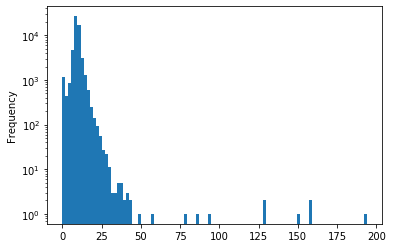

In [130]:
np.sqrt(av).plot(kind='hist', bins=100, logy=True)

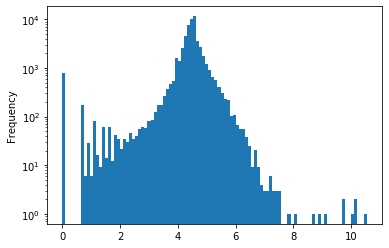

In [132]:
np.log(av+1).plot(kind='hist', bins=100, logy=True)

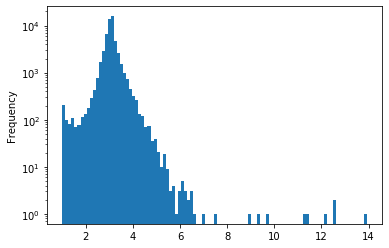

In [147]:
np.sqrt(np.sqrt(av)).plot(kind='hist', bins=100, logy=True)

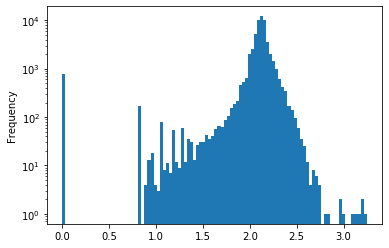

In [131]:
np.sqrt(np.log(av+1)).plot(kind='hist', bins=100, logy=True)

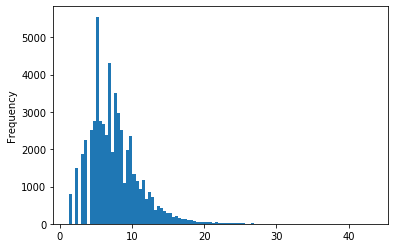

In [70]:
at.plot(kind='hist', bins=100)

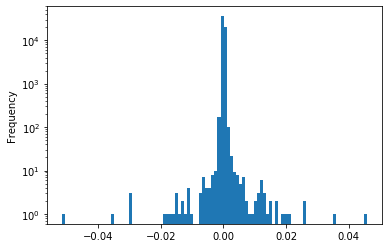

In [53]:
aapl.open.plot(kind='hist', bins=100, logy=True)

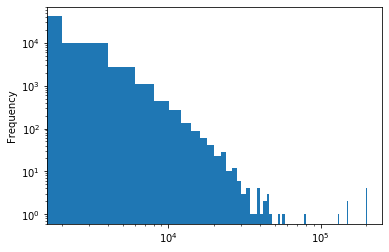

In [54]:
aapl.volume.plot(kind='hist', bins=100, loglog=True)

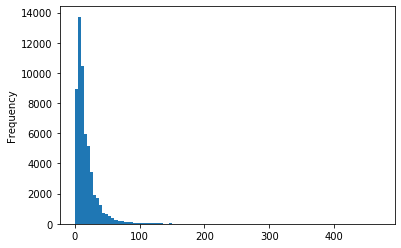

In [55]:
aapl.numberOfTrades.plot(kind='hist', bins=100)

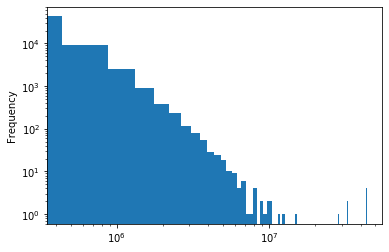

In [56]:
aapl.notional.plot(kind='hist', bins=100, loglog=True)

In [57]:
aapl.count()

open              56366
close             56366
high              56366
low               56366
average           56366
volume            56366
notional          56366
numberOfTrades    56366
dtype: int64

In [ ]:
next_avgs = aapl[['close']]
next_avgs['datetime'] = next_avgs.index
next_avgs['datetime'] = next_avgs['datetime'].apply(lambda dt: dt - Δ(minutes=1))
next_avgs.set_index('datetime', inplace=True)
next_avgs.rename(columns={'close': 'next_close'}, inplace=True)
next_avgs

In [ ]:
aapl = aapl.merge(next_avgs, how='left', left_index=True, right_index=True).dropna(subset=['next_close']); aapl

In [ ]:
aapl.count()

In [ ]:
aapl['validation'] = vfs; aapl

In [ ]:
aapl.to_csv(data_dir / 'aapl.csv')

In [ ]:
cols = features + [ 'next_close' ]
trn = aapl[~aapl.validation][cols]
val = aapl[ aapl.validation][cols]
stats = \
    concat(
        [ 
            trn.mean(axis=0).rename('mean'), 
            trn.std(axis=0).rename('stddev') 
        ], 
        axis=1
    ) \
    .transpose(copy=True)

means = stats.loc['mean']
stddevs = stats.loc['stddev']

stats

In [ ]:
normed = (aapl[cols] - means[cols]) / stddevs[cols]; normed

In [ ]:
concat(
    [ 
        normed[~aapl.validation].mean(axis=0).rename('train_mean'), 
        normed[~aapl.validation].std(axis=0).rename('train_stddev'),
        normed[ aapl.validation].mean(axis=0).rename('val_mean'), 
        normed[ aapl.validation].std(axis=0).rename('val_stddev'),
        normed                  .mean(axis=0).rename('mean'), 
        normed                  .std(axis=0).rename('stddev'),
    ], 
    axis=1
)

In [ ]:
window = 30

def make_windowed_array(feature):        
    col = normed[feature]
    df = concat([ col.shift(lag) for lag in reversed(range(window)) ], axis=1)
    return df.values

array([ make_windowed_array for feature in features ])[(window-1):]

In [ ]:
normed

## Window size: 20

In [ ]:
aapl = array([ load_data_arr(date, ticker) for date in dates ]); aapl.shape

In [ ]:
shape = aapl.shape
aapl = aapl.reshape((shape[0] * shape[1], shape[2]))
avg = features.index('average')
avgs = aapl[:, avg]
shape = aapl.shape; shape

In [ ]:
y = np.roll(avgs, -1)
y = y[:-1]
x = aapl[:-1]
x.shape, y.shape

In [ ]:
window = 20
n = x.shape[0]
x = np.array([ x[i:(i+window)] for i in range(n-window+1) ])
y = y[(window-1):]
x.shape, y.shape

In [ ]:
idxs = np.logical_and([ (cnz(na(row)) == 0) for row in x ], ~na(y))
y = y[idxs]
x = x[idxs]
x.shape, y.shape

In [ ]:
n = x.shape[0]

In [ ]:
xa = x[:, -1, avg]
xa[:10], y[:10]

In [ ]:
cnz(xa > y), cnz(xa < y), cnz(xa == y)

In [ ]:
(xa - y).max(), (xa - y).min()

In [ ]:
mean((xa - y)**2)

-------

In [ ]:
ox = x.copy()
oy = y.copy()

In [ ]:
x = ox
y = oy

In [ ]:
perm = permutation(n); perm

In [ ]:
x = x[perm]
y = y[perm]

In [ ]:
val_split = 0.1
tn = int((1 - val_split) * n)
vn = n - tn
tx = x[:tn]
ty = y[:tn]
vx = x[tn:]
vy = y[tn:]
[ a.shape for a in [tx,ty,vx,vy] ]

In [ ]:
u = mean(tx[:, -1, :], axis=0)
s = std(tx[:, -1, :], axis=0)
x = (x - u) / s
y = (y - u[avg]) / s[avg]
mean(x[:, -1, :], axis=0), std(x[:, -1, :], axis=0), mean(y), std(y)

In [ ]:
val_split = 0.1
tn = int((1 - val_split) * n)
vn = n - tn
tx = x[:tn]
ty = y[:tn]
vx = x[tn:]
vy = y[tn:]
[ a.shape for a in [tx,ty,vx,vy] ]

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras import Sequential

In [ ]:
model = Sequential()
model.add(SimpleRNN(4, input_shape=(window, len(features))))
model.add(Dense(1))
model.build()
model.compile(loss='mae', optimizer='adam')
model.summary()

In [ ]:
px = model.predict(vx)
px.max() - px.min(), x[:10, -1, 0], y[:10], px[:10, -1]

In [ ]:
mean(abs(tx[:, -1, avg] - ty)), mean(abs(vx[:, -1, avg] - vy)), mean(abs(x[:, -1, avg] - y))

In [ ]:
%%time
model.fit(x, y, 
          validation_split=0.1,
          batch_size=n,
          epochs=100000)

px = model.predict(x)
res = np.swapaxes(array([x[:10, -1, 0], y[:10], px[:10, -1]]), 0, 1)
px.max() - px.min(), res

In [ ]:
w = model.get_weights(); w, [ l.shape for l in w ]

In [ ]:
describe(ty)